# CHURN ANALYSIS

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [74]:
df = pd.read_csv('telecom_churn.csv')

In [75]:
df.dtypes

customer_id              int64
telecom_partner         object
gender                  object
age                      int64
state                   object
city                    object
pincode                  int64
date_of_registration    object
num_dependents           int64
estimated_salary         int64
calls_made               int64
sms_sent                 int64
data_used                int64
churn                    int64
dtype: object

### DATA CLEANING

In [76]:
df.customer_id.duplicated().any()

False

No duplicated values

In [77]:
df.isnull().values.any()

False

No missing values

In [78]:
age_bins = [18, 25, 35, 45, 55, 100]  
age_labels = ['18-25', '26-35', '36-45', '46-55', '56+']
df['age_group'] = pd.cut(df.age, bins=age_bins, labels= age_labels, right=False)

Ages makes more sense when in groups

In [79]:
df.date_of_registration = pd.to_datetime(df.date_of_registration)
df['year_reg'] = df.date_of_registration.dt.year
df['month_reg'] = df.date_of_registration.dt.month
df['day_reg'] = df.date_of_registration.dt.day

Date into ints as well

### EDA

##### Partners

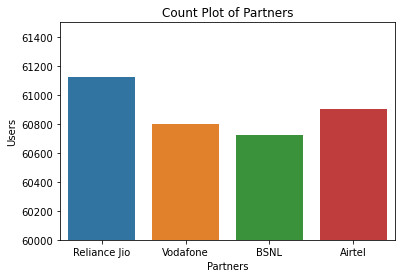

In [20]:
sns.countplot(x='telecom_partner', data=df)
plt.title('Count Plot of Partners')
plt.xlabel('Partners')
plt.ylabel('Users')
plt.ylim(60000, 61500)
plt.show()

In [21]:
df.telecom_partner.value_counts()

Reliance Jio    61123
Airtel          60905
Vodafone        60802
BSNL            60723
Name: telecom_partner, dtype: int64

##### Gender

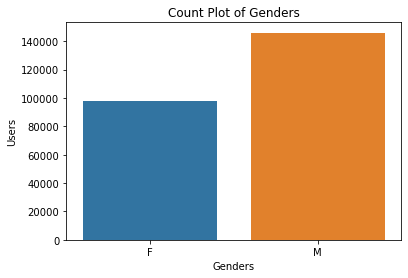

In [23]:
sns.countplot(x='gender', data=df)
plt.title('Count Plot of Genders')
plt.xlabel('Genders')
plt.ylabel('Users')
plt.show()

##### Age

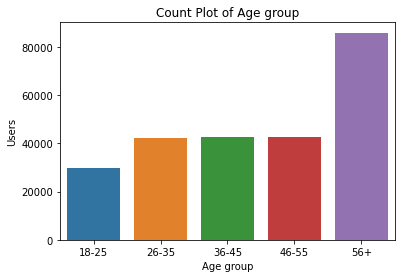

In [42]:
sns.countplot(x='age_group', data=df)
# plt.bins()
plt.title('Count Plot of Age group')
plt.xlabel('Age group')
# plt.xticks(rotation=90)
plt.ylabel('Users')
plt.show()

##### State

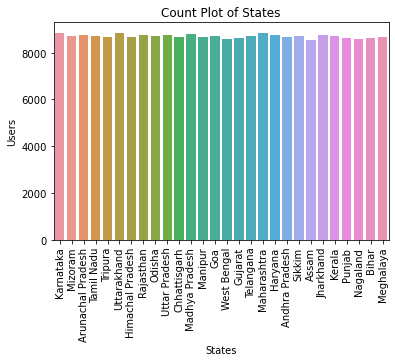

In [33]:
sns.countplot(x='state', data=df)
plt.title('Count Plot of States')
plt.xlabel('States')
plt.xticks(rotation=90)
plt.ylabel('Users')
plt.show()

##### City

this does not make sense, there are more states than cities. clearly this dataset is coocked (or even created from scratch)

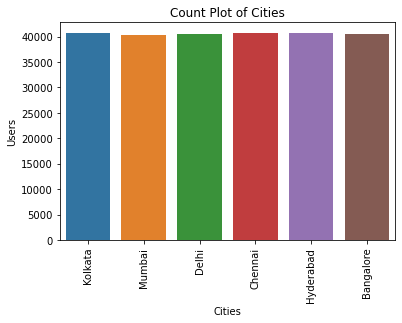

In [44]:
sns.countplot(x='city', data=df)
plt.title('Count Plot of Cities')
plt.xlabel('Cities')
plt.xticks(rotation=90)
plt.ylabel('Users')
plt.show()

##### Year

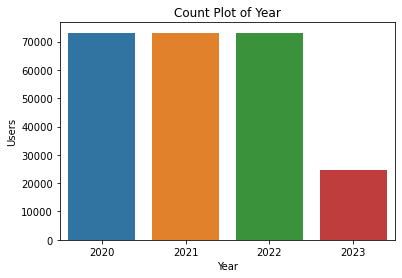

In [57]:
sns.countplot(x='year_reg', data=df)
plt.title('Count Plot of Year')
plt.xlabel('Year')
plt.ylabel('Users')
plt.show()

##### Num dependents

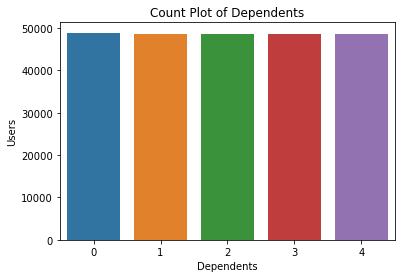

In [56]:
sns.countplot(x='num_dependents', data=df)
plt.title('Count Plot of Dependents')
plt.xlabel('Dependents')
plt.ylabel('Users')
plt.show()

##### Churn

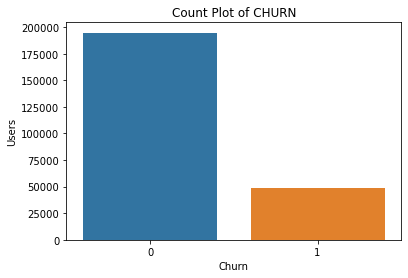

In [63]:
sns.countplot(x='churn', data=df)
plt.title('Count Plot of CHURN')
plt.xlabel('Churn')
plt.ylabel('Users')
plt.show()

#### Correlation Matrix

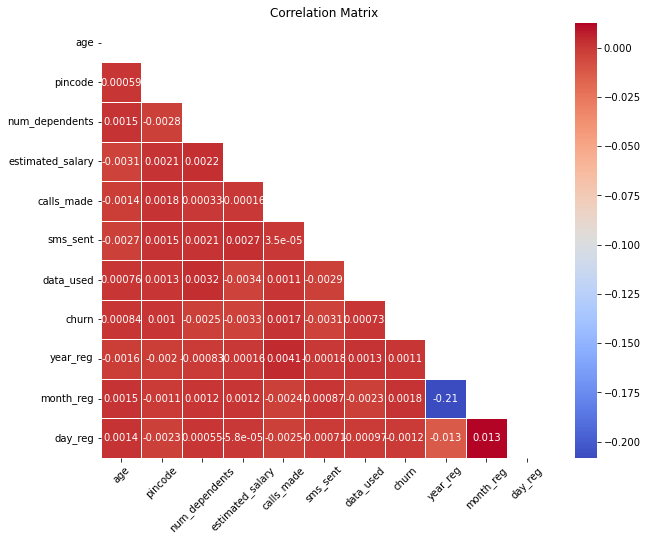

In [68]:
num_cols = df.columns != 'customer_id'
df_num = df.loc[:, num_cols]
corr_matrix = df_num.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Let's make sure every variable is numeric

In [117]:
df_num['gender_F'] = pd.get_dummies(df.gender)['F']
df_num = pd.concat([df, pd.get_dummies(df.telecom_partner, 'partner')], axis=1)
df_num = pd.concat([df, pd.get_dummies(df.city, 'city')], axis=1)
df_num = df_num.drop(['telecom_partner', 'state', 'gender', 'city', 'age_group','date_of_registration'], axis=1)

In [118]:
len(df_num.dtypes)

19

### BINARY CLASIFICATION NN

In [128]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(18,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [129]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                1216      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [131]:
X = df_num.loc[:, df_num.columns != 'churn'].to_numpy()
y = df_num.loc[:, 'churn'].to_numpy()

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_val = y_val.astype(np.float32)

In [133]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


2023-06-16 17:07:14.288923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6089/6089 [==============================] - ETA: 0s - loss: 352.0332 - accuracy: 0.6780

2023-06-16 17:07:51.448893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6089/6089 [==============================] - 42s 7ms/step - loss: 352.0332 - accuracy: 0.6780 - val_loss: 137.0515 - val_accuracy: 0.7985
Epoch 2/10
6089/6089 [==============================] - 41s 7ms/step - loss: 84.5485 - accuracy: 0.6791 - val_loss: 10.2851 - val_accuracy: 0.4528
Epoch 3/10
6089/6089 [==============================] - 41s 7ms/step - loss: 32.9837 - accuracy: 0.6785 - val_loss: 38.0949 - val_accuracy: 0.7991
Epoch 4/10
6089/6089 [==============================] - 41s 7ms/step - loss: 7.3558 - accuracy: 0.6855 - val_loss: 0.9777 - val_accuracy: 0.4386
Epoch 5/10
6089/6089 [==============================] - 41s 7ms/step - loss: 0.5501 - accuracy: 0.7878 - val_loss: 0.5031 - val_accuracy: 0.7991
Epoch 6/10
6089/6089 [==============================] - 42s 7ms/step - loss: 0.5025 - accuracy: 0.7995 - val_loss: 0.5017 - val_accuracy: 0.7991
Epoch 7/10
6089/6089 [==============================] - 41s 7ms/step - loss: 0.5009 - accuracy: 0.7996 - val_loss: 0.5017 - val_accur